In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#---------------------------------------------#
#    CREATE THE VAE                           #
#---------------------------------------------#
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), #16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), #32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), #64, 1, 1
            nn.ReLU(),
            Compress()
            )


        self.fc_mu = nn.Linear(64, 64)
        self.fc_logvar = nn.Linear(64, 64)



        #64, 1, 1
        self.decoder = nn.Sequential(
            Decompress(),
            nn.ConvTranspose2d(64, 32, 7), #32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), #1, 28, 28
            nn.Sigmoid()
            )

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        e = torch.randn_like(std)
        z = mu + (std * e)
        return z

    def generateExample(self, num_examples):
        #x must be 64, 1, 1 tensor
        mu = torch.zeros(num_examples, 64).to("cuda")
        logvar = torch.ones(num_examples, 64).to("cuda")
        z = self.sample(mu, logvar)

        return self.decoder(z)

    def forward(self, x):
        #print(f"Before encoding: {x.shape}")
        x = self.encoder(x)
        #print(f"After encoding: {x.shape}")
        mu = self.fc_mu(x)
        #mu = torch.zeros(10, 64).to("cuda")
        #print(f"Mean (mu) Shape: {mu.shape}")
        logvar = self.fc_logvar(x)
        #logvar = torch.ones(10, 64).to("cuda")
        #print(f"Log Variance Shape: {logvar.shape}")
        z = self.sample(mu, logvar)
        #print(f"Z Shape: {z.shape}")
        recon_x = self.decoder(z)
        #mu 0 logvar 1 for recon
        #print(f"Reconstructed x After Decoding: {recon_x.shape}")
        return recon_x, mu, logvar

class Compress(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Decompress(nn.Module):
    def forward(self, input, size=28*28):
        #print(input.view(input.size(0), input.size(1), 1, 1).shape)
        return input.view(input.size(0), input.size(1), 1, 1)

def loss_fn(recon_x, x, mu, logvar):
    #use squared error MSELoss
    loss = functional.mse_loss(recon_x, x, reduction="sum")
    #BCELoss = functional.binary_cross_entropy(recon_x, x, reduction="sum")
    KL_Div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss + KL_Div
    #return BCELoss + KL_Div

In [ ]:
#Create data loaders
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

#------------------------------------#
#           SHOW THE IMAGES          #
#------------------------------------#

def showImage(img, img_recon, epoch):
    #unnormalize
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    #img = img/2 + 0.5
    img = img.numpy()
    plt.title(label="Original Epoch: #"+str(epoch))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    fig.add_subplot(1, 2, 2)
    #img_recon = img_recon/2 + 0.5
    img_recon = img_recon.numpy()
    plt.title(label="Reconstruction Epoch: #"+str(epoch))
    plt.imshow(np.transpose(img_recon, (1, 2, 0)))
    plt.show(block=True)

def showExample(img):
    #unnormalize
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    #img = img/2 + 0.5
    img = img.numpy()
    plt.title(label="Generated Example")
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show(block=True)

#dataiter = iter(train_dataloader)
#images, labels = dataiter.next()

#show images
#showImage(torchvision.utils.make_grid(images))


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}\n")
#training the VAE initially

#one image channel because black and white
model = VAE().to(device)

learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
epochs = 12
running_loss = 0.0



NameError: name 'dataset' is not defined

Epoch 1
-----------------------------------


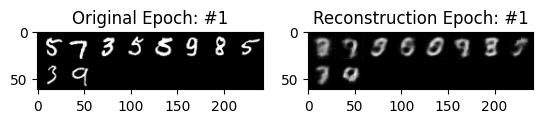

loss: 544.472


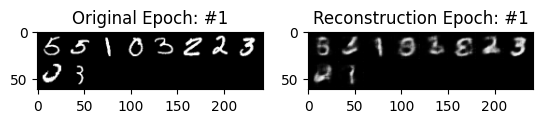

loss: 418.784


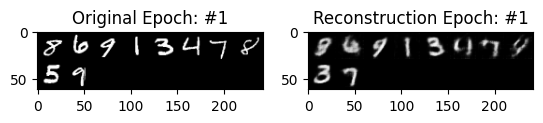

loss: 371.340
Epoch 2
-----------------------------------


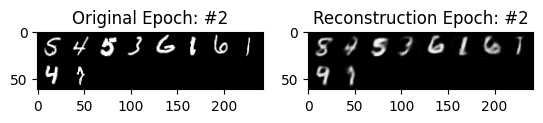

loss: 350.623


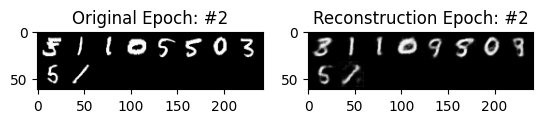

loss: 341.861


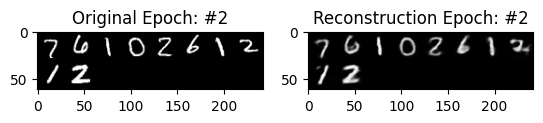

loss: 337.413
Epoch 3
-----------------------------------


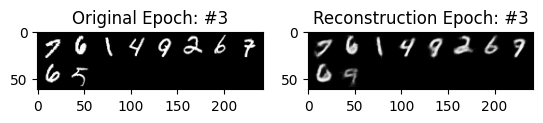

loss: 331.953


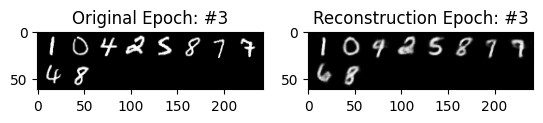

loss: 329.167


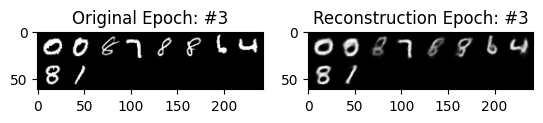

loss: 326.386
Epoch 4
-----------------------------------


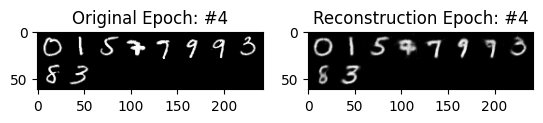

loss: 323.614


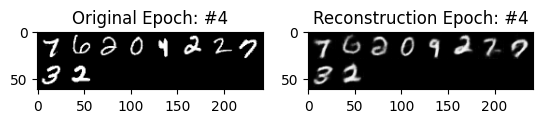

loss: 322.446


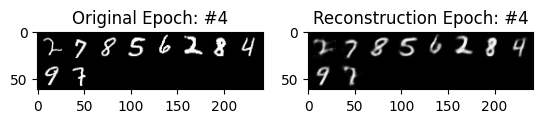

loss: 320.234
Epoch 5
-----------------------------------


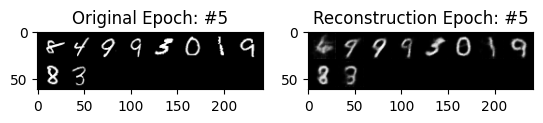

loss: 319.615


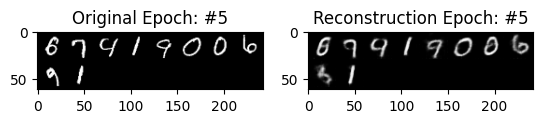

loss: 318.890


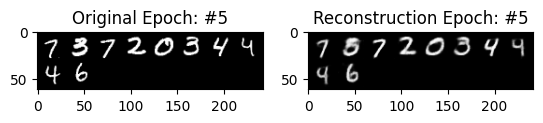

loss: 316.492
Epoch 6
-----------------------------------


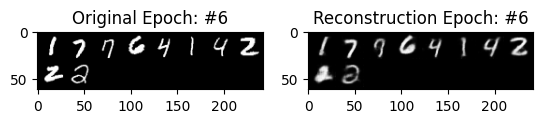

loss: 315.656


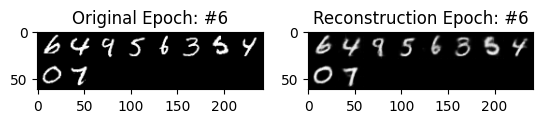

loss: 316.268


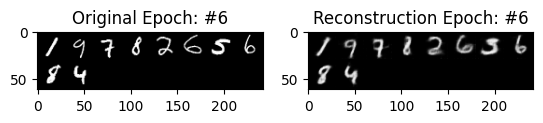

loss: 312.963
Epoch 7
-----------------------------------


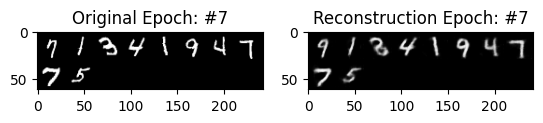

loss: 312.015


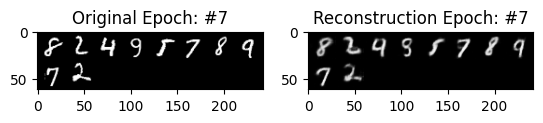

loss: 312.331


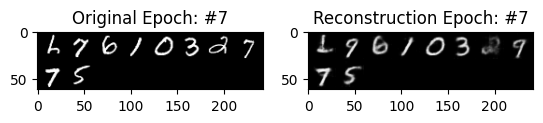

loss: 312.075
Epoch 8
-----------------------------------


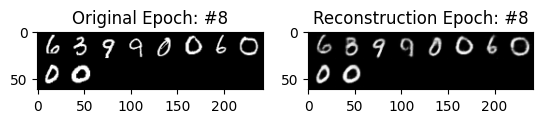

loss: 311.911


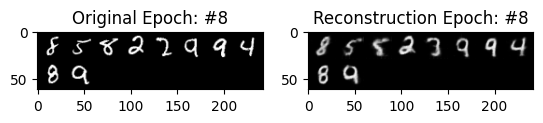

loss: 309.970


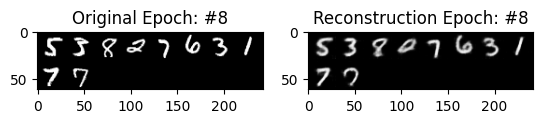

loss: 309.324
Epoch 9
-----------------------------------


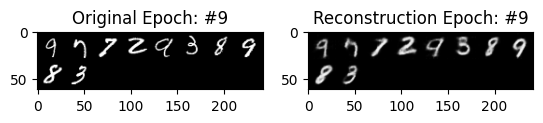

loss: 309.203


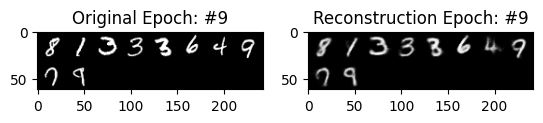

loss: 309.502


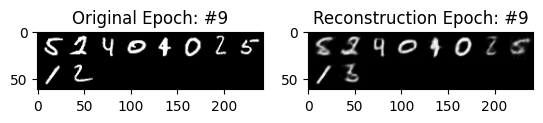

loss: 307.545
Epoch 10
-----------------------------------


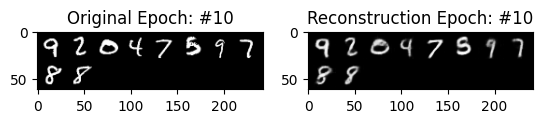

loss: 307.125


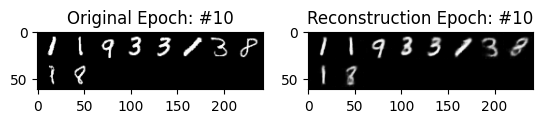

loss: 307.841


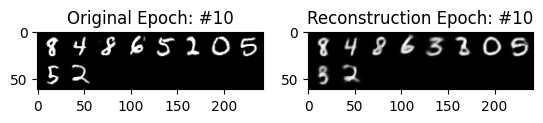

loss: 307.424
Epoch 11
-----------------------------------


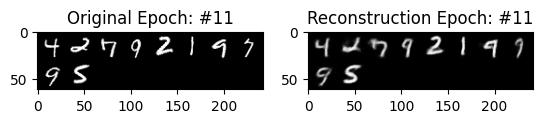

loss: 306.646


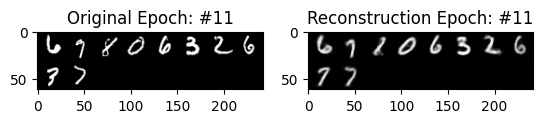

loss: 306.215


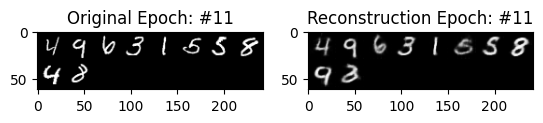

loss: 305.209
Epoch 12
-----------------------------------


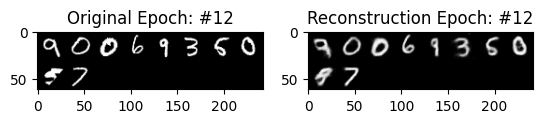

loss: 303.862


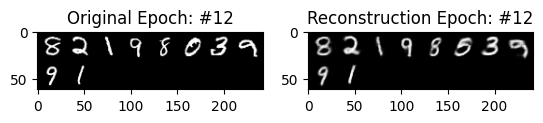

loss: 305.351


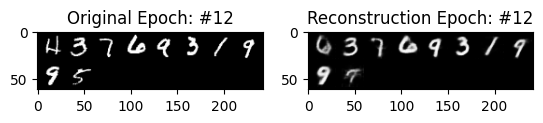

loss: 306.235


In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    for idx, (images, _) in enumerate(train_dataloader):
        #running_loss = 0.0
        images = images.to(device)
        recon_x, mu, logvar = model(images)
        loss = loss_fn(recon_x, images, mu, logvar)
         # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if idx % 2000 == 1999:    # print every 2000 mini-batches
            #output the original image and the reconstructed image
            showImage(torchvision.utils.make_grid(images.to("cpu")), torchvision.utils.make_grid(recon_x.to("cpu")), t+1)
            #showImage(torchvision.utils.make_grid(recon_x.to("cpu")))
            print('loss: %.3f' %(running_loss / 2000))
            running_loss = 0.0
    #print(f"Done with epoch #{t+1}\n")